In [19]:
'''
Author       : Hanqing Qi
Date         : 2023-06-17 16:22:33
LastEditors  : Hanqing Qi
LastEditTime : 2023-06-17 16:27:40
FilePath     : /Rotation_Test_2/Simulation_1.ipynb
Description  : Simulation 1 for Spinning Mochi
'''

# Import packages
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import Cone
import importlib as imp
imp.reload(Cone)

# Parameters
View_Angle = 80  # View angle of the cone
View_Distance = 10  # View distance of the cone
Frame_Number = 400  # Number of frames
Frame_Interval = 100  # Time interval between frames


In [20]:
# Functions
def Generate_Agents(Filename, Graph_Size, Number):
    '''
    description : Generate a graph with random positions and save the data to Filename.txt
    param        [*] Filename
    param        [*] Graph_Size
    param        [*] Number
    return       [*] pos
    '''
    pos = {}
    for n in range(Number):
        # Generate random positions with 2 digits after the decimal point
        x = round(random.uniform(0, Graph_Size), 2)
        y = round(random.uniform(0, Graph_Size), 2)
        pos[str(n)] = (x, y)
        # print('Agent %s: (%s, %s)' % (n, x, y))
    # Save the data to Filename.txt
    with open(Filename, 'w') as f:
        for node in pos:
            f.write('%s:%s\n' % (node, pos[node]))


def Load_Positions(Filename):
    '''
    description : Load the data from Filename.txt and generate a graph
    param        [*] Filename
    return       [*]
    '''
    G = nx.Graph()
    with open(Filename, 'r') as f:
        for line in f:
            node, pos = line.strip().split(':')
            G.add_node(node, pos=eval(pos))
    return G


def Draw_Graph(G, ax):
    '''
    description : Draw the graph
    param        [*] G
    return       [*]
    '''
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, ax=ax, node_size=10, node_color='black')


def Generate_Cones(G):
    '''
    description : Generate cones for all the agents
    param        [*] G
    return       [*] cones
    '''
    cones = []
    for node in G.nodes:
        center = G.nodes[node]['pos']
        radius = View_Distance
        # Generate a random starting angle with 2 digits after the decimal point
        starting_angle = round(random.uniform(0, 360), 2)
        end_angle = starting_angle + View_Angle
        cones.append(Cone.Cone(center, radius, starting_angle, end_angle, None))
    return cones


def Save_Cones(Filename, cones):
    '''
    description : Save the cones to Filename.txt
    param        [*] Filename
    param        [*] cones
    return       [*]
    '''
    with open(Filename, 'w') as f:
        for cone in cones:
            f.write('%s\n' % cone.format_out())


def Load_Cones(Filename):
    cones = []
    with open(Filename, 'r') as f:
        for line in f:
            center, radius, starting_angle, end_angle = line.strip().split(':')
            cones.append(
                Cone.Cone(
                    eval(center),
                    eval(radius),
                    eval(starting_angle),
                    eval(end_angle),
                    None,
                )
            )
    return cones


def Simulation(cones):
    Data = []
    for f in range(Frame_Number):
        # Rotate the cones
        for i, cone in enumerate(cones):
            cone.rotate(10 * (-1) ** i)
        View = []
        for i in range(len(cones)):
            for j in range(i + 1, len(cones)):
                if cones[i].insight(cones[j].getCenter()) and cones[j].insight(
                    cones[i].getCenter()
                ):
                    View.append((i, j))
        Data.append(View)

    # Save the data to Data.txt
    with open('Data.txt', 'w') as f:
        for i in range(len(Data)):
            f.write('%s\n' % Data[i])

    return Data


def Load_Data():
    Data = []
    with open('Data.txt', 'r') as f:
        for line in f:
            Data.append(eval(line.strip()))
    return Data

In [21]:
# Parameters
Graph_Size = 50
Node_Number = 100

In [22]:
# Generate_Agents('pos.txt', Graph_Size, Node_Number)
G = Load_Positions('pos.txt')
# Draw_Graph(G)
cones = Generate_Cones(G)
Save_Cones('cones.txt', cones)
# cones = Load_Cones('cones.txt')

In [23]:
Data = Simulation(cones)
# Draw_Graph(G)
# Refresh Cones
cones = Load_Cones('cones.txt')

Rendering frames: 401it [00:29, 13.81it/s]                                      


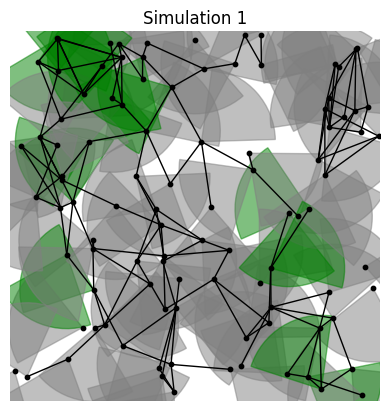

In [24]:
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

# Draw the anination using the data
fig, ax = plt.subplots()


def animate(t):
    pbar.update()
    ax.clear()
    plt.title('Simulation 1')
    plt.xlim(0, Graph_Size)
    plt.ylim(0, Graph_Size)
    temp = []
    if Data[t] != []:
        for entries in Data[t]:
            # Add the edge if there were no edge
            if not G.has_edge(str(entries[0]), str(entries[1])):
                G.add_edge(str(entries[0]), str(entries[1]))
            temp.append(entries[0])
            temp.append(entries[1])
    for i in range(len(cones)):
        if i not in temp:
            cones[i].Draw_Cone(ax, 'grey')
        else:
            cones[i].Draw_Cone(ax, 'green')
    ax.set_aspect('equal', adjustable='box')
    ax.grid()
    Draw_Graph(G, ax)
    for i, cone in enumerate(cones):
        cone.rotate(10 * (-1) ** i)


frame = np.arange(0, Frame_Number, 1)
pbar = tqdm(total=len(frame), desc="Rendering frames", ncols=80)
anim = FuncAnimation(
    fig, animate, frames=frame, interval=Frame_Interval
)  # interval increased for slower animation

# Save the animation as a mp4 file
anim.save(
    'simulation-' + str(View_Distance) + '-' + str(View_Angle) + '.mp4', writer='ffmpeg'
)
pbar.close()